In [1]:
%load_ext autoreload
%autoreload 2
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
import numpy as onp
import jax

import distrax
import jax.numpy as jnp
import haiku as hk
from jaxline import utils

import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.utils import flatten_nested_dict
import wandb
print(jax.devices())

2023-08-14 15:43:44.473727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-14 15:43:44.473817: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-14 15:43:44.473826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
from dds.objectives import controlled_ais_relative_kl_objective
from dds.objectives import controlled_ais_importance_weighted_partition_estimate_dds


config = get_config()

# Time and step settings (Need to be done before calling set_task)
config.model.tfinal = 6.4
# config.model.tfinal = 10
config.model.dt = 0.05

config.model.reference_process_key = "cais"

config.trainer.objective = controlled_ais_relative_kl_objective
config.trainer.lnz_is_estimator = controlled_ais_importance_weighted_partition_estimate_dds

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"

config = set_task(config, "funnel")

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"
    
    # Opt setting for funnel
    config.model.sigma = 1.3
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False

if config.model.reference_process_key == "cais":
    config.model.step_scheme_key = "linear"
    
    # Opt setting for funnel
    config.model.sigma = 1.1
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False


config.model.stl = False
config.model.detach_stl_drift = False

config.trainer.notebook = True
config.trainer.epochs = 200  #  11000
# Opt settings we use
# funnel_config.trainer.learning_rate = 0.0001
config.trainer.learning_rate = 5 * 10**(-3)
config.trainer.lr_sch_base_dec = 0.95 # For funnel
config.model.reference_process_key = "cais"
# config.trainer.learning_rate = 0
config.trainer.epochs = 6000
config.trainer.learning_rate = 1 * 10**(-5)

In [3]:
def update_detached_params(trainable_params, non_trainable_params,
                           attached_network_name="simple_drift_net",
                           detached_network_name="stl_detach"):
  """Auxiliary function updating detached params for STL.

  Args:
      trainable_params:
      non_trainable_params:
      attached_network_name:
      detached_network_name:
  Returns:
    Returns non trainable params
  """

  if len(trainable_params) != len(non_trainable_params):
    return non_trainable_params

  for key in trainable_params.keys():
    if attached_network_name in key:
      key_det = key.replace(attached_network_name, detached_network_name)
    else:
      key_det = key.replace("diffusion_network",
                            detached_network_name + "_diff")
    non_trainable_params[key_det] = trainable_params[key]  # pytype: disable=unsupported-operands

  return non_trainable_params

data_dim = config.model.input_dim
device_no = jax.device_count()

results_path = '~/denoising_diffusion_samplers/results'
alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

# post setup model vars
config.model.source_obj = distrax.MultivariateNormalDiag(
    jnp.zeros(config.model.input_dim),
    config.model.sigma * jnp.ones(config.model.input_dim))
config.model.source = config.model.source_obj.log_prob

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp"
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path, config.model.detach_path)

target = config.model.target

tfinal = config.model.tfinal
lnpi = config.trainer.lnpi

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower()
        else 1)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"


# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}" +
            f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}" +
            f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk")
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift if
    "detach_stl_drift" in config.model else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

In [4]:
from turtle import forward


def _forward_fn(batch_size: int,
                training: bool = True,
                ode=False, exact=False, dt_=dt) -> jnp.ndarray:

    model_def = ref_proc(
        sigma, 
        data_dim, 
        drift_network, 
        tfinal=tfinal, 
        dt=dt_,
        step_scheme=step_scheme, 
        alpha=alpha, 
        target=target, 
        tpu=tpu,
        detach_stl_drift=detach_stl_drift, 
        diff_net=None,
        detach_dritf_path=detach_dritf_path, 
        detach_dif_path=detach_dif_path,
        m=m, 
        log=config.model.log, 
        exp_bool=config.model.exp_dds, 
        exact=exact
    )

    return model_def(batch_size, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)  

print(forward_fn)


TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7f3d18f9f490>, apply=<function transform_with_state.<locals>.apply_fn at 0x7f3d18f9f640>)


In [5]:
# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(forward_fn.init, batch_size=batch_size_,
                        training=True), axis_name="num_devices")

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params)

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                transition_steps, base_dec)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3, 4, 5, 6))
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False,  dt_=dt):

    samps, _ = forward_fn.apply(
        params,
        model_state,
        subkeys,
        int(batch_size / device_no),
        False,
        ode=ode, exact=exact, dt_=dt_)
    samps = jax.device_get(samps)

    augmented_trajectory, ts = samps
    return (augmented_trajectory, ts), _

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False, dt_=dt):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts), _ = forward_fn_jit(params, model_state,
                                                subkeys, batch_size, ode, exact,
                                                dt_)

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv*ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts)), _

In [6]:
def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
  ):

  params = hk.data_structures.merge(trainable_params, non_trainable_params)
  (augmented_trajectory, _), model_state = forward_fn.apply(
      params, model_state, rng_key, batch_size, True, ode, exact
  )

  # import pdb; pdb.set_trace()
  gpartial = functools.partial(
      config.model.terminal_cost,
      lnpi=lnpi, sigma=sigma, tfinal=tfinal, brown=brown)
  
  if is_training:
    loss = config.trainer.objective(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, stl=stl, trim=trim, dim=data_dim)
  elif not ode:
    loss = config.trainer.lnz_is_estimator(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, dim=data_dim)
  else:
    loss = config.trainer.lnz_pf_estimator(
        augmented_trajectory, config.model.source, config.model.target)
  return loss, model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5,))
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray):
  grads, new_model_state = jax.grad(
      full_objective, has_aux=True)(
          trainable_params,
          non_trainable_params,
          model_state,
          rng_key,
          batch_size,
          is_training=True,
          stl=stl)
  grads = jax.lax.pmean(grads, axis_name="num_devices")

  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(trainable_params, updates)
  return new_params, opt_state, new_model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4, 5, 6, 7))
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,):

  loss, new_model_state = full_objective(
      trainable_params,
      non_trainable_params,
      model_state,
      rng_key,
      batch_size,
      is_training=is_training, ode=ode,
      stl=False, exact=exact,)

  loss = jax.lax.pmean(loss, axis_name="num_devices")
  return loss, new_model_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
) -> None:

  loss, model_state = jited_val_loss(
      trainable_params, non_trainable_params,
      model_state, rng_key, batch_size, is_training, ode, exact)
  loss = jax.device_get(loss)
  loss = onp.asarray(utils.get_first(loss).item()).item()

  log_string = "epoch: %s %s  loss: %s", epoch, "TRAIN", loss
  logging.info(log_string)
  if config.trainer.notebook and print_flag: print(log_string)

  loss_list.append(loss)
  if wandb_run:
    wandb_run.log({f"{wandb_key}/epoch": epoch, f"{wandb_key}/loss": loss})
  # writer.flush()

loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
times = []

run = None

for epoch in range(start, config.trainer.epochs):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  
  if epoch == 0:
      eval_report(trainable_params, non_trainable_params,
                    model_state, subkeys, batch_size_elbo, epoch - 1,
                    loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")
  if config.trainer.epochs == 1:
    break

  trainable_params, opt_state, model_state = update(trainable_params,
                                                    non_trainable_params,
                                                    model_state, opt_state,
                                                    subkeys, batch_size_)
  if config.trainer.timer:
    def func():
      return jax.block_until_ready(
          update(trainable_params, non_trainable_params, model_state,
                opt_state, subkeys, batch_size_))

    delta_time = timeit.timeit(func, number=1)
    times.append(delta_time)

  update_detached_params(trainable_params, non_trainable_params,
                        "simple_drift_net", "stl_detach")

  if epoch % config.trainer.log_every_n_epochs == 0:

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_is, is_training=False, wandb_run=run, wandb_key="is_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_pf, is_training=False, ode=True, wandb_run=run, wandb_key="pf_results")

    lr = onp.asarray(exp_lr(epoch).item()).item()
    if run:
        run.log({"lr/epoch": epoch, "lr/lr": lr})

loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_eval,
      print_flag=True,
      wandb_run=run,
      wandb_key="elbo_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_is_eval,
      is_training=False,
      wandb_run=run,
      wandb_key="is_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_pf_eval,
      is_training=False, ode=True, exact=False,
      wandb_run=run,
      wandb_key="pf_results_eval",)

params = hk.data_structures.merge(trainable_params, non_trainable_params)
if config.trainer.timer:
  print(times[1:])

samps = 2500
if method == "lgcp" and tfinal >= 12:
  samps = 100

(augmented_trajectory, _), _ = forward_fn_wrap(params, model_state, rng_key,
                                              samps)

(augmented_trajectory_det, _), _ = forward_fn_wrap(params, model_state,
                                                  rng_key, samps, True, False)
  
(augmented_trajectory_det_ext, _), _ = forward_fn_wrap(params, model_state,
                                                      rng_key, samps, True, True)


results_dict = {
    "elbo": loss_list,
    "is": loss_list_is,
    "pf": loss_list_pf,
    "elbo_eval": loss_list_eval,
    "is_eval": loss_list_is_eval,
    "pf_eval": loss_list_pf_eval,
    "aug": augmented_trajectory,
    "aug_ode": augmented_trajectory_det,
    "aug_ode_ext": augmented_trajectory_det_ext
}

('epoch: %s %s  loss: %s', -1, 'TRAIN', 1.2358803749084473)
('epoch: %s %s  loss: %s', 0, 'TRAIN', 1.2356890439987183)
('epoch: %s %s  loss: %s', 1, 'TRAIN', 1.260153889656067)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 1.263163447380066)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 1.239799976348877)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 1.2338331937789917)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 1.2615511417388916)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 1.2174129486083984)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 1.2805503606796265)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 1.2756179571151733)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 1.270432710647583)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 1.2869473695755005)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 1.2574001550674438)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 1.2274492979049683)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 1.2262929677963257)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 1.2311183214187622)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 1.297395348548

('epoch: %s %s  loss: %s', 136, 'TRAIN', 1.2467111349105835)
('epoch: %s %s  loss: %s', 137, 'TRAIN', 1.2281280755996704)
('epoch: %s %s  loss: %s', 138, 'TRAIN', 1.227769374847412)
('epoch: %s %s  loss: %s', 139, 'TRAIN', 1.2147544622421265)
('epoch: %s %s  loss: %s', 140, 'TRAIN', 1.2619621753692627)
('epoch: %s %s  loss: %s', 141, 'TRAIN', 1.2583622932434082)
('epoch: %s %s  loss: %s', 142, 'TRAIN', 1.1987102031707764)
('epoch: %s %s  loss: %s', 143, 'TRAIN', 1.2384155988693237)
('epoch: %s %s  loss: %s', 144, 'TRAIN', 1.2008130550384521)
('epoch: %s %s  loss: %s', 145, 'TRAIN', 1.2342458963394165)
('epoch: %s %s  loss: %s', 146, 'TRAIN', 1.2189396619796753)
('epoch: %s %s  loss: %s', 147, 'TRAIN', 1.1908687353134155)
('epoch: %s %s  loss: %s', 148, 'TRAIN', 1.231811285018921)
('epoch: %s %s  loss: %s', 149, 'TRAIN', 1.239343523979187)
('epoch: %s %s  loss: %s', 150, 'TRAIN', 1.1899083852767944)
('epoch: %s %s  loss: %s', 151, 'TRAIN', 1.2415499687194824)
('epoch: %s %s  loss: %s', 

('epoch: %s %s  loss: %s', 271, 'TRAIN', 1.1875792741775513)
('epoch: %s %s  loss: %s', 272, 'TRAIN', 1.211269736289978)
('epoch: %s %s  loss: %s', 273, 'TRAIN', 1.2376463413238525)
('epoch: %s %s  loss: %s', 274, 'TRAIN', 1.1561033725738525)
('epoch: %s %s  loss: %s', 275, 'TRAIN', 1.2010475397109985)
('epoch: %s %s  loss: %s', 276, 'TRAIN', 1.219264268875122)
('epoch: %s %s  loss: %s', 277, 'TRAIN', 1.1553645133972168)
('epoch: %s %s  loss: %s', 278, 'TRAIN', 1.1971830129623413)
('epoch: %s %s  loss: %s', 279, 'TRAIN', 1.173136830329895)
('epoch: %s %s  loss: %s', 280, 'TRAIN', 1.1857103109359741)
('epoch: %s %s  loss: %s', 281, 'TRAIN', 1.1925556659698486)
('epoch: %s %s  loss: %s', 282, 'TRAIN', 1.1539182662963867)
('epoch: %s %s  loss: %s', 283, 'TRAIN', 1.2284481525421143)
('epoch: %s %s  loss: %s', 284, 'TRAIN', 1.1874607801437378)
('epoch: %s %s  loss: %s', 285, 'TRAIN', 1.2065367698669434)
('epoch: %s %s  loss: %s', 286, 'TRAIN', 1.1771012544631958)
('epoch: %s %s  loss: %s', 

('epoch: %s %s  loss: %s', 406, 'TRAIN', 1.2367839813232422)
('epoch: %s %s  loss: %s', 407, 'TRAIN', 1.2255916595458984)
('epoch: %s %s  loss: %s', 408, 'TRAIN', 1.1901214122772217)
('epoch: %s %s  loss: %s', 409, 'TRAIN', 1.1712695360183716)
('epoch: %s %s  loss: %s', 410, 'TRAIN', 1.2490837574005127)
('epoch: %s %s  loss: %s', 411, 'TRAIN', 1.1306239366531372)
('epoch: %s %s  loss: %s', 412, 'TRAIN', 1.183968424797058)
('epoch: %s %s  loss: %s', 413, 'TRAIN', 1.168902039527893)
('epoch: %s %s  loss: %s', 414, 'TRAIN', 1.1918425559997559)
('epoch: %s %s  loss: %s', 415, 'TRAIN', 1.194032073020935)
('epoch: %s %s  loss: %s', 416, 'TRAIN', 1.1650270223617554)
('epoch: %s %s  loss: %s', 417, 'TRAIN', 1.194589376449585)
('epoch: %s %s  loss: %s', 418, 'TRAIN', 1.2330958843231201)
('epoch: %s %s  loss: %s', 419, 'TRAIN', 1.1912304162979126)
('epoch: %s %s  loss: %s', 420, 'TRAIN', 1.2128463983535767)
('epoch: %s %s  loss: %s', 421, 'TRAIN', 1.1795154809951782)
('epoch: %s %s  loss: %s', 4

('epoch: %s %s  loss: %s', 541, 'TRAIN', 1.2153410911560059)
('epoch: %s %s  loss: %s', 542, 'TRAIN', 1.1631778478622437)
('epoch: %s %s  loss: %s', 543, 'TRAIN', 1.1747277975082397)
('epoch: %s %s  loss: %s', 544, 'TRAIN', 1.1785471439361572)
('epoch: %s %s  loss: %s', 545, 'TRAIN', 1.143592119216919)
('epoch: %s %s  loss: %s', 546, 'TRAIN', 1.184356451034546)
('epoch: %s %s  loss: %s', 547, 'TRAIN', 1.2012512683868408)
('epoch: %s %s  loss: %s', 548, 'TRAIN', 1.1706140041351318)
('epoch: %s %s  loss: %s', 549, 'TRAIN', 1.1485410928726196)
('epoch: %s %s  loss: %s', 550, 'TRAIN', 1.1610634326934814)
('epoch: %s %s  loss: %s', 551, 'TRAIN', 1.1579139232635498)
('epoch: %s %s  loss: %s', 552, 'TRAIN', 1.206377387046814)
('epoch: %s %s  loss: %s', 553, 'TRAIN', 1.1755356788635254)
('epoch: %s %s  loss: %s', 554, 'TRAIN', 1.1802479028701782)
('epoch: %s %s  loss: %s', 555, 'TRAIN', 1.1963833570480347)
('epoch: %s %s  loss: %s', 556, 'TRAIN', 1.1259937286376953)
('epoch: %s %s  loss: %s', 

('epoch: %s %s  loss: %s', 676, 'TRAIN', 1.1981781721115112)
('epoch: %s %s  loss: %s', 677, 'TRAIN', 1.200103998184204)
('epoch: %s %s  loss: %s', 678, 'TRAIN', 1.1745561361312866)
('epoch: %s %s  loss: %s', 679, 'TRAIN', 1.1898972988128662)
('epoch: %s %s  loss: %s', 680, 'TRAIN', 1.1599332094192505)
('epoch: %s %s  loss: %s', 681, 'TRAIN', 1.1716457605361938)
('epoch: %s %s  loss: %s', 682, 'TRAIN', 1.1907854080200195)
('epoch: %s %s  loss: %s', 683, 'TRAIN', 1.1969729661941528)
('epoch: %s %s  loss: %s', 684, 'TRAIN', 1.1902920007705688)
('epoch: %s %s  loss: %s', 685, 'TRAIN', 1.137961983680725)
('epoch: %s %s  loss: %s', 686, 'TRAIN', 1.1942105293273926)
('epoch: %s %s  loss: %s', 687, 'TRAIN', 1.1838642358779907)
('epoch: %s %s  loss: %s', 688, 'TRAIN', 1.168012261390686)
('epoch: %s %s  loss: %s', 689, 'TRAIN', 1.1680166721343994)
('epoch: %s %s  loss: %s', 690, 'TRAIN', 1.1933989524841309)
('epoch: %s %s  loss: %s', 691, 'TRAIN', 1.2281595468521118)
('epoch: %s %s  loss: %s', 

('epoch: %s %s  loss: %s', 811, 'TRAIN', 1.1902661323547363)
('epoch: %s %s  loss: %s', 812, 'TRAIN', 1.2216585874557495)
('epoch: %s %s  loss: %s', 813, 'TRAIN', 1.2084757089614868)
('epoch: %s %s  loss: %s', 814, 'TRAIN', 1.2014074325561523)
('epoch: %s %s  loss: %s', 815, 'TRAIN', 1.1847407817840576)
('epoch: %s %s  loss: %s', 816, 'TRAIN', 1.2092888355255127)
('epoch: %s %s  loss: %s', 817, 'TRAIN', 1.1603882312774658)
('epoch: %s %s  loss: %s', 818, 'TRAIN', 1.1637556552886963)
('epoch: %s %s  loss: %s', 819, 'TRAIN', 1.1596990823745728)
('epoch: %s %s  loss: %s', 820, 'TRAIN', 1.1774859428405762)
('epoch: %s %s  loss: %s', 821, 'TRAIN', 1.2157678604125977)
('epoch: %s %s  loss: %s', 822, 'TRAIN', 1.1401499509811401)
('epoch: %s %s  loss: %s', 823, 'TRAIN', 1.1824146509170532)
('epoch: %s %s  loss: %s', 824, 'TRAIN', 1.1907869577407837)
('epoch: %s %s  loss: %s', 825, 'TRAIN', 1.2010481357574463)
('epoch: %s %s  loss: %s', 826, 'TRAIN', 1.1623038053512573)
('epoch: %s %s  loss: %s

('epoch: %s %s  loss: %s', 946, 'TRAIN', 1.1822707653045654)
('epoch: %s %s  loss: %s', 947, 'TRAIN', 1.1840288639068604)
('epoch: %s %s  loss: %s', 948, 'TRAIN', 1.1819348335266113)
('epoch: %s %s  loss: %s', 949, 'TRAIN', 1.1652617454528809)
('epoch: %s %s  loss: %s', 950, 'TRAIN', 1.168161153793335)
('epoch: %s %s  loss: %s', 951, 'TRAIN', 1.2050682306289673)
('epoch: %s %s  loss: %s', 952, 'TRAIN', 1.2009552717208862)
('epoch: %s %s  loss: %s', 953, 'TRAIN', 1.1571455001831055)
('epoch: %s %s  loss: %s', 954, 'TRAIN', 1.2050256729125977)
('epoch: %s %s  loss: %s', 955, 'TRAIN', 1.1727834939956665)
('epoch: %s %s  loss: %s', 956, 'TRAIN', 1.1732218265533447)
('epoch: %s %s  loss: %s', 957, 'TRAIN', 1.1727252006530762)
('epoch: %s %s  loss: %s', 958, 'TRAIN', 1.1840929985046387)
('epoch: %s %s  loss: %s', 959, 'TRAIN', 1.1680059432983398)
('epoch: %s %s  loss: %s', 960, 'TRAIN', 1.1933938264846802)
('epoch: %s %s  loss: %s', 961, 'TRAIN', 1.1880548000335693)
('epoch: %s %s  loss: %s'

('epoch: %s %s  loss: %s', 1080, 'TRAIN', 1.238947868347168)
('epoch: %s %s  loss: %s', 1081, 'TRAIN', 1.1571028232574463)
('epoch: %s %s  loss: %s', 1082, 'TRAIN', 1.192862868309021)
('epoch: %s %s  loss: %s', 1083, 'TRAIN', 1.1859954595565796)
('epoch: %s %s  loss: %s', 1084, 'TRAIN', 1.1392730474472046)
('epoch: %s %s  loss: %s', 1085, 'TRAIN', 1.223084568977356)
('epoch: %s %s  loss: %s', 1086, 'TRAIN', 1.1662646532058716)
('epoch: %s %s  loss: %s', 1087, 'TRAIN', 1.1481863260269165)
('epoch: %s %s  loss: %s', 1088, 'TRAIN', 1.2047039270401)
('epoch: %s %s  loss: %s', 1089, 'TRAIN', 1.151086688041687)
('epoch: %s %s  loss: %s', 1090, 'TRAIN', 1.188260793685913)
('epoch: %s %s  loss: %s', 1091, 'TRAIN', 1.1826518774032593)
('epoch: %s %s  loss: %s', 1092, 'TRAIN', 1.1817705631256104)
('epoch: %s %s  loss: %s', 1093, 'TRAIN', 1.1953516006469727)
('epoch: %s %s  loss: %s', 1094, 'TRAIN', 1.1592940092086792)
('epoch: %s %s  loss: %s', 1095, 'TRAIN', 1.1412546634674072)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 1213, 'TRAIN', 1.1880532503128052)
('epoch: %s %s  loss: %s', 1214, 'TRAIN', 1.1860499382019043)
('epoch: %s %s  loss: %s', 1215, 'TRAIN', 1.1779348850250244)
('epoch: %s %s  loss: %s', 1216, 'TRAIN', 1.1343860626220703)
('epoch: %s %s  loss: %s', 1217, 'TRAIN', 1.1624196767807007)
('epoch: %s %s  loss: %s', 1218, 'TRAIN', 1.163232445716858)
('epoch: %s %s  loss: %s', 1219, 'TRAIN', 1.1824228763580322)
('epoch: %s %s  loss: %s', 1220, 'TRAIN', 1.2090519666671753)
('epoch: %s %s  loss: %s', 1221, 'TRAIN', 1.2089747190475464)
('epoch: %s %s  loss: %s', 1222, 'TRAIN', 1.191220760345459)
('epoch: %s %s  loss: %s', 1223, 'TRAIN', 1.141852855682373)
('epoch: %s %s  loss: %s', 1224, 'TRAIN', 1.1857736110687256)
('epoch: %s %s  loss: %s', 1225, 'TRAIN', 1.160791039466858)
('epoch: %s %s  loss: %s', 1226, 'TRAIN', 1.1697365045547485)
('epoch: %s %s  loss: %s', 1227, 'TRAIN', 1.1629043817520142)
('epoch: %s %s  loss: %s', 1228, 'TRAIN', 1.2021523714065552)
('epoch: %s 

('epoch: %s %s  loss: %s', 1346, 'TRAIN', 1.1498051881790161)
('epoch: %s %s  loss: %s', 1347, 'TRAIN', 1.210031509399414)
('epoch: %s %s  loss: %s', 1348, 'TRAIN', 1.2054035663604736)
('epoch: %s %s  loss: %s', 1349, 'TRAIN', 1.2072415351867676)
('epoch: %s %s  loss: %s', 1350, 'TRAIN', 1.1759036779403687)
('epoch: %s %s  loss: %s', 1351, 'TRAIN', 1.168870210647583)
('epoch: %s %s  loss: %s', 1352, 'TRAIN', 1.1842401027679443)
('epoch: %s %s  loss: %s', 1353, 'TRAIN', 1.193405270576477)
('epoch: %s %s  loss: %s', 1354, 'TRAIN', 1.1449613571166992)
('epoch: %s %s  loss: %s', 1355, 'TRAIN', 1.1661585569381714)
('epoch: %s %s  loss: %s', 1356, 'TRAIN', 1.1534035205841064)
('epoch: %s %s  loss: %s', 1357, 'TRAIN', 1.1762675046920776)
('epoch: %s %s  loss: %s', 1358, 'TRAIN', 1.1609578132629395)
('epoch: %s %s  loss: %s', 1359, 'TRAIN', 1.1342642307281494)
('epoch: %s %s  loss: %s', 1360, 'TRAIN', 1.205877423286438)
('epoch: %s %s  loss: %s', 1361, 'TRAIN', 1.1526002883911133)
('epoch: %s 

('epoch: %s %s  loss: %s', 1479, 'TRAIN', 1.1760051250457764)
('epoch: %s %s  loss: %s', 1480, 'TRAIN', 1.1530086994171143)
('epoch: %s %s  loss: %s', 1481, 'TRAIN', 1.1769896745681763)
('epoch: %s %s  loss: %s', 1482, 'TRAIN', 1.1546365022659302)
('epoch: %s %s  loss: %s', 1483, 'TRAIN', 1.1445907354354858)
('epoch: %s %s  loss: %s', 1484, 'TRAIN', 1.2100739479064941)
('epoch: %s %s  loss: %s', 1485, 'TRAIN', 1.1367456912994385)
('epoch: %s %s  loss: %s', 1486, 'TRAIN', 1.1850218772888184)
('epoch: %s %s  loss: %s', 1487, 'TRAIN', 1.1786936521530151)
('epoch: %s %s  loss: %s', 1488, 'TRAIN', 1.1777007579803467)
('epoch: %s %s  loss: %s', 1489, 'TRAIN', 1.1606990098953247)
('epoch: %s %s  loss: %s', 1490, 'TRAIN', 1.1745991706848145)
('epoch: %s %s  loss: %s', 1491, 'TRAIN', 1.2000203132629395)
('epoch: %s %s  loss: %s', 1492, 'TRAIN', 1.1940579414367676)
('epoch: %s %s  loss: %s', 1493, 'TRAIN', 1.2007932662963867)
('epoch: %s %s  loss: %s', 1494, 'TRAIN', 1.1930394172668457)
('epoch:

('epoch: %s %s  loss: %s', 1612, 'TRAIN', 1.1640201807022095)
('epoch: %s %s  loss: %s', 1613, 'TRAIN', 1.1137821674346924)
('epoch: %s %s  loss: %s', 1614, 'TRAIN', 1.1616913080215454)
('epoch: %s %s  loss: %s', 1615, 'TRAIN', 1.2213008403778076)
('epoch: %s %s  loss: %s', 1616, 'TRAIN', 1.161801815032959)
('epoch: %s %s  loss: %s', 1617, 'TRAIN', 1.1905235052108765)
('epoch: %s %s  loss: %s', 1618, 'TRAIN', 1.2072097063064575)
('epoch: %s %s  loss: %s', 1619, 'TRAIN', 1.158247709274292)
('epoch: %s %s  loss: %s', 1620, 'TRAIN', 1.1682671308517456)
('epoch: %s %s  loss: %s', 1621, 'TRAIN', 1.1993228197097778)
('epoch: %s %s  loss: %s', 1622, 'TRAIN', 1.1714516878128052)
('epoch: %s %s  loss: %s', 1623, 'TRAIN', 1.1862794160842896)
('epoch: %s %s  loss: %s', 1624, 'TRAIN', 1.1670844554901123)
('epoch: %s %s  loss: %s', 1625, 'TRAIN', 1.166427731513977)
('epoch: %s %s  loss: %s', 1626, 'TRAIN', 1.1910547018051147)
('epoch: %s %s  loss: %s', 1627, 'TRAIN', 1.232966423034668)
('epoch: %s 

('epoch: %s %s  loss: %s', 1745, 'TRAIN', 1.161245584487915)
('epoch: %s %s  loss: %s', 1746, 'TRAIN', 1.1676708459854126)
('epoch: %s %s  loss: %s', 1747, 'TRAIN', 1.1809641122817993)
('epoch: %s %s  loss: %s', 1748, 'TRAIN', 1.2202907800674438)
('epoch: %s %s  loss: %s', 1749, 'TRAIN', 1.1917388439178467)
('epoch: %s %s  loss: %s', 1750, 'TRAIN', 1.1674013137817383)
('epoch: %s %s  loss: %s', 1751, 'TRAIN', 1.1768988370895386)
('epoch: %s %s  loss: %s', 1752, 'TRAIN', 1.1886805295944214)
('epoch: %s %s  loss: %s', 1753, 'TRAIN', 1.1785811185836792)
('epoch: %s %s  loss: %s', 1754, 'TRAIN', 1.1902705430984497)
('epoch: %s %s  loss: %s', 1755, 'TRAIN', 1.1212856769561768)
('epoch: %s %s  loss: %s', 1756, 'TRAIN', 1.15312659740448)
('epoch: %s %s  loss: %s', 1757, 'TRAIN', 1.1707966327667236)
('epoch: %s %s  loss: %s', 1758, 'TRAIN', 1.1844329833984375)
('epoch: %s %s  loss: %s', 1759, 'TRAIN', 1.1739537715911865)
('epoch: %s %s  loss: %s', 1760, 'TRAIN', 1.1350301504135132)
('epoch: %s

('epoch: %s %s  loss: %s', 1878, 'TRAIN', 1.1752005815505981)
('epoch: %s %s  loss: %s', 1879, 'TRAIN', 1.190009593963623)
('epoch: %s %s  loss: %s', 1880, 'TRAIN', 1.1670619249343872)
('epoch: %s %s  loss: %s', 1881, 'TRAIN', 1.1968857049942017)
('epoch: %s %s  loss: %s', 1882, 'TRAIN', 1.162671446800232)
('epoch: %s %s  loss: %s', 1883, 'TRAIN', 1.1795015335083008)
('epoch: %s %s  loss: %s', 1884, 'TRAIN', 1.173091173171997)
('epoch: %s %s  loss: %s', 1885, 'TRAIN', 1.1910969018936157)
('epoch: %s %s  loss: %s', 1886, 'TRAIN', 1.1863288879394531)
('epoch: %s %s  loss: %s', 1887, 'TRAIN', 1.2173314094543457)
('epoch: %s %s  loss: %s', 1888, 'TRAIN', 1.1940579414367676)
('epoch: %s %s  loss: %s', 1889, 'TRAIN', 1.1913598775863647)
('epoch: %s %s  loss: %s', 1890, 'TRAIN', 1.2047663927078247)
('epoch: %s %s  loss: %s', 1891, 'TRAIN', 1.2067549228668213)
('epoch: %s %s  loss: %s', 1892, 'TRAIN', 1.1614991426467896)
('epoch: %s %s  loss: %s', 1893, 'TRAIN', 1.2078105211257935)
('epoch: %s

('epoch: %s %s  loss: %s', 2011, 'TRAIN', 1.1981433629989624)
('epoch: %s %s  loss: %s', 2012, 'TRAIN', 1.1828572750091553)
('epoch: %s %s  loss: %s', 2013, 'TRAIN', 1.173450231552124)
('epoch: %s %s  loss: %s', 2014, 'TRAIN', 1.1897982358932495)
('epoch: %s %s  loss: %s', 2015, 'TRAIN', 1.1659826040267944)
('epoch: %s %s  loss: %s', 2016, 'TRAIN', 1.1891648769378662)
('epoch: %s %s  loss: %s', 2017, 'TRAIN', 1.198081612586975)
('epoch: %s %s  loss: %s', 2018, 'TRAIN', 1.164145827293396)
('epoch: %s %s  loss: %s', 2019, 'TRAIN', 1.1625896692276)
('epoch: %s %s  loss: %s', 2020, 'TRAIN', 1.1783576011657715)
('epoch: %s %s  loss: %s', 2021, 'TRAIN', 1.157419204711914)
('epoch: %s %s  loss: %s', 2022, 'TRAIN', 1.2068870067596436)
('epoch: %s %s  loss: %s', 2023, 'TRAIN', 1.2210317850112915)
('epoch: %s %s  loss: %s', 2024, 'TRAIN', 1.1558512449264526)
('epoch: %s %s  loss: %s', 2025, 'TRAIN', 1.2131489515304565)
('epoch: %s %s  loss: %s', 2026, 'TRAIN', 1.2026203870773315)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 2144, 'TRAIN', 1.2089085578918457)
('epoch: %s %s  loss: %s', 2145, 'TRAIN', 1.174321174621582)
('epoch: %s %s  loss: %s', 2146, 'TRAIN', 1.1781196594238281)
('epoch: %s %s  loss: %s', 2147, 'TRAIN', 1.1534762382507324)
('epoch: %s %s  loss: %s', 2148, 'TRAIN', 1.2150238752365112)
('epoch: %s %s  loss: %s', 2149, 'TRAIN', 1.1997705698013306)
('epoch: %s %s  loss: %s', 2150, 'TRAIN', 1.1597007513046265)
('epoch: %s %s  loss: %s', 2151, 'TRAIN', 1.1755696535110474)
('epoch: %s %s  loss: %s', 2152, 'TRAIN', 1.185633897781372)
('epoch: %s %s  loss: %s', 2153, 'TRAIN', 1.1934154033660889)
('epoch: %s %s  loss: %s', 2154, 'TRAIN', 1.209063172340393)
('epoch: %s %s  loss: %s', 2155, 'TRAIN', 1.1524364948272705)
('epoch: %s %s  loss: %s', 2156, 'TRAIN', 1.1560018062591553)
('epoch: %s %s  loss: %s', 2157, 'TRAIN', 1.205945372581482)
('epoch: %s %s  loss: %s', 2158, 'TRAIN', 1.1710078716278076)
('epoch: %s %s  loss: %s', 2159, 'TRAIN', 1.1602548360824585)
('epoch: %s 

('epoch: %s %s  loss: %s', 2277, 'TRAIN', 1.2346054315567017)
('epoch: %s %s  loss: %s', 2278, 'TRAIN', 1.196922779083252)
('epoch: %s %s  loss: %s', 2279, 'TRAIN', 1.1621414422988892)
('epoch: %s %s  loss: %s', 2280, 'TRAIN', 1.1562693119049072)
('epoch: %s %s  loss: %s', 2281, 'TRAIN', 1.1674482822418213)
('epoch: %s %s  loss: %s', 2282, 'TRAIN', 1.1893107891082764)
('epoch: %s %s  loss: %s', 2283, 'TRAIN', 1.1861937046051025)
('epoch: %s %s  loss: %s', 2284, 'TRAIN', 1.1644713878631592)
('epoch: %s %s  loss: %s', 2285, 'TRAIN', 1.1656849384307861)
('epoch: %s %s  loss: %s', 2286, 'TRAIN', 1.1724779605865479)
('epoch: %s %s  loss: %s', 2287, 'TRAIN', 1.173979640007019)
('epoch: %s %s  loss: %s', 2288, 'TRAIN', 1.1865167617797852)
('epoch: %s %s  loss: %s', 2289, 'TRAIN', 1.1685513257980347)
('epoch: %s %s  loss: %s', 2290, 'TRAIN', 1.175424575805664)
('epoch: %s %s  loss: %s', 2291, 'TRAIN', 1.1959048509597778)
('epoch: %s %s  loss: %s', 2292, 'TRAIN', 1.181617021560669)
('epoch: %s 

('epoch: %s %s  loss: %s', 2410, 'TRAIN', 1.1501134634017944)
('epoch: %s %s  loss: %s', 2411, 'TRAIN', 1.1293030977249146)
('epoch: %s %s  loss: %s', 2412, 'TRAIN', 1.1857820749282837)
('epoch: %s %s  loss: %s', 2413, 'TRAIN', 1.2158840894699097)
('epoch: %s %s  loss: %s', 2414, 'TRAIN', 1.2044998407363892)
('epoch: %s %s  loss: %s', 2415, 'TRAIN', 1.1551504135131836)
('epoch: %s %s  loss: %s', 2416, 'TRAIN', 1.170487642288208)
('epoch: %s %s  loss: %s', 2417, 'TRAIN', 1.188207983970642)
('epoch: %s %s  loss: %s', 2418, 'TRAIN', 1.1818443536758423)
('epoch: %s %s  loss: %s', 2419, 'TRAIN', 1.2229008674621582)
('epoch: %s %s  loss: %s', 2420, 'TRAIN', 1.1644268035888672)
('epoch: %s %s  loss: %s', 2421, 'TRAIN', 1.2116565704345703)
('epoch: %s %s  loss: %s', 2422, 'TRAIN', 1.144211769104004)
('epoch: %s %s  loss: %s', 2423, 'TRAIN', 1.1896138191223145)
('epoch: %s %s  loss: %s', 2424, 'TRAIN', 1.2081130743026733)
('epoch: %s %s  loss: %s', 2425, 'TRAIN', 1.1988588571548462)
('epoch: %s

('epoch: %s %s  loss: %s', 2543, 'TRAIN', 1.1547520160675049)
('epoch: %s %s  loss: %s', 2544, 'TRAIN', 1.1665161848068237)
('epoch: %s %s  loss: %s', 2545, 'TRAIN', 1.2099705934524536)
('epoch: %s %s  loss: %s', 2546, 'TRAIN', 1.1656873226165771)
('epoch: %s %s  loss: %s', 2547, 'TRAIN', 1.172627329826355)
('epoch: %s %s  loss: %s', 2548, 'TRAIN', 1.1932287216186523)
('epoch: %s %s  loss: %s', 2549, 'TRAIN', 1.170828104019165)
('epoch: %s %s  loss: %s', 2550, 'TRAIN', 1.1515905857086182)
('epoch: %s %s  loss: %s', 2551, 'TRAIN', 1.1645586490631104)
('epoch: %s %s  loss: %s', 2552, 'TRAIN', 1.1932952404022217)
('epoch: %s %s  loss: %s', 2553, 'TRAIN', 1.200456142425537)
('epoch: %s %s  loss: %s', 2554, 'TRAIN', 1.1967756748199463)
('epoch: %s %s  loss: %s', 2555, 'TRAIN', 1.1550213098526)
('epoch: %s %s  loss: %s', 2556, 'TRAIN', 1.1760884523391724)
('epoch: %s %s  loss: %s', 2557, 'TRAIN', 1.204386830329895)
('epoch: %s %s  loss: %s', 2558, 'TRAIN', 1.1880395412445068)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 2676, 'TRAIN', 1.1711667776107788)
('epoch: %s %s  loss: %s', 2677, 'TRAIN', 1.1424368619918823)
('epoch: %s %s  loss: %s', 2678, 'TRAIN', 1.1886980533599854)
('epoch: %s %s  loss: %s', 2679, 'TRAIN', 1.1733455657958984)
('epoch: %s %s  loss: %s', 2680, 'TRAIN', 1.2010188102722168)
('epoch: %s %s  loss: %s', 2681, 'TRAIN', 1.1530483961105347)
('epoch: %s %s  loss: %s', 2682, 'TRAIN', 1.1874805688858032)
('epoch: %s %s  loss: %s', 2683, 'TRAIN', 1.1166738271713257)
('epoch: %s %s  loss: %s', 2684, 'TRAIN', 1.188947081565857)
('epoch: %s %s  loss: %s', 2685, 'TRAIN', 1.2072632312774658)
('epoch: %s %s  loss: %s', 2686, 'TRAIN', 1.1522517204284668)
('epoch: %s %s  loss: %s', 2687, 'TRAIN', 1.1922727823257446)
('epoch: %s %s  loss: %s', 2688, 'TRAIN', 1.1648643016815186)
('epoch: %s %s  loss: %s', 2689, 'TRAIN', 1.1749894618988037)
('epoch: %s %s  loss: %s', 2690, 'TRAIN', 1.17458975315094)
('epoch: %s %s  loss: %s', 2691, 'TRAIN', 1.1361026763916016)
('epoch: %s

('epoch: %s %s  loss: %s', 2809, 'TRAIN', 1.1956974267959595)
('epoch: %s %s  loss: %s', 2810, 'TRAIN', 1.2016338109970093)
('epoch: %s %s  loss: %s', 2811, 'TRAIN', 1.1712361574172974)
('epoch: %s %s  loss: %s', 2812, 'TRAIN', 1.2048945426940918)
('epoch: %s %s  loss: %s', 2813, 'TRAIN', 1.196045160293579)
('epoch: %s %s  loss: %s', 2814, 'TRAIN', 1.1643412113189697)
('epoch: %s %s  loss: %s', 2815, 'TRAIN', 1.187057614326477)
('epoch: %s %s  loss: %s', 2816, 'TRAIN', 1.1541460752487183)
('epoch: %s %s  loss: %s', 2817, 'TRAIN', 1.211571455001831)
('epoch: %s %s  loss: %s', 2818, 'TRAIN', 1.2066059112548828)
('epoch: %s %s  loss: %s', 2819, 'TRAIN', 1.1607972383499146)
('epoch: %s %s  loss: %s', 2820, 'TRAIN', 1.1966238021850586)
('epoch: %s %s  loss: %s', 2821, 'TRAIN', 1.179774522781372)
('epoch: %s %s  loss: %s', 2822, 'TRAIN', 1.161916732788086)
('epoch: %s %s  loss: %s', 2823, 'TRAIN', 1.1525845527648926)
('epoch: %s %s  loss: %s', 2824, 'TRAIN', 1.181427001953125)
('epoch: %s %s

('epoch: %s %s  loss: %s', 2942, 'TRAIN', 1.2066987752914429)
('epoch: %s %s  loss: %s', 2943, 'TRAIN', 1.2105447053909302)
('epoch: %s %s  loss: %s', 2944, 'TRAIN', 1.127813458442688)
('epoch: %s %s  loss: %s', 2945, 'TRAIN', 1.1788092851638794)
('epoch: %s %s  loss: %s', 2946, 'TRAIN', 1.1735057830810547)
('epoch: %s %s  loss: %s', 2947, 'TRAIN', 1.1393017768859863)
('epoch: %s %s  loss: %s', 2948, 'TRAIN', 1.2058207988739014)
('epoch: %s %s  loss: %s', 2949, 'TRAIN', 1.1479412317276)
('epoch: %s %s  loss: %s', 2950, 'TRAIN', 1.1757113933563232)
('epoch: %s %s  loss: %s', 2951, 'TRAIN', 1.2103328704833984)
('epoch: %s %s  loss: %s', 2952, 'TRAIN', 1.178495168685913)
('epoch: %s %s  loss: %s', 2953, 'TRAIN', 1.1850389242172241)
('epoch: %s %s  loss: %s', 2954, 'TRAIN', 1.1831063032150269)
('epoch: %s %s  loss: %s', 2955, 'TRAIN', 1.1866645812988281)
('epoch: %s %s  loss: %s', 2956, 'TRAIN', 1.177886962890625)
('epoch: %s %s  loss: %s', 2957, 'TRAIN', 1.200525164604187)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 3075, 'TRAIN', 1.1558327674865723)
('epoch: %s %s  loss: %s', 3076, 'TRAIN', 1.1576486825942993)
('epoch: %s %s  loss: %s', 3077, 'TRAIN', 1.1718679666519165)
('epoch: %s %s  loss: %s', 3078, 'TRAIN', 1.211403489112854)
('epoch: %s %s  loss: %s', 3079, 'TRAIN', 1.2122083902359009)
('epoch: %s %s  loss: %s', 3080, 'TRAIN', 1.1760164499282837)
('epoch: %s %s  loss: %s', 3081, 'TRAIN', 1.1558806896209717)
('epoch: %s %s  loss: %s', 3082, 'TRAIN', 1.1956754922866821)
('epoch: %s %s  loss: %s', 3083, 'TRAIN', 1.1658589839935303)
('epoch: %s %s  loss: %s', 3084, 'TRAIN', 1.1640229225158691)
('epoch: %s %s  loss: %s', 3085, 'TRAIN', 1.1880602836608887)
('epoch: %s %s  loss: %s', 3086, 'TRAIN', 1.1479551792144775)
('epoch: %s %s  loss: %s', 3087, 'TRAIN', 1.1919145584106445)
('epoch: %s %s  loss: %s', 3088, 'TRAIN', 1.208099126815796)
('epoch: %s %s  loss: %s', 3089, 'TRAIN', 1.2106683254241943)
('epoch: %s %s  loss: %s', 3090, 'TRAIN', 1.1774753332138062)
('epoch: %

('epoch: %s %s  loss: %s', 3208, 'TRAIN', 1.1781092882156372)
('epoch: %s %s  loss: %s', 3209, 'TRAIN', 1.1930474042892456)
('epoch: %s %s  loss: %s', 3210, 'TRAIN', 1.1893044710159302)
('epoch: %s %s  loss: %s', 3211, 'TRAIN', 1.181787133216858)
('epoch: %s %s  loss: %s', 3212, 'TRAIN', 1.1899640560150146)
('epoch: %s %s  loss: %s', 3213, 'TRAIN', 1.1775386333465576)
('epoch: %s %s  loss: %s', 3214, 'TRAIN', 1.185088872909546)
('epoch: %s %s  loss: %s', 3215, 'TRAIN', 1.2068930864334106)
('epoch: %s %s  loss: %s', 3216, 'TRAIN', 1.1968410015106201)
('epoch: %s %s  loss: %s', 3217, 'TRAIN', 1.181858777999878)
('epoch: %s %s  loss: %s', 3218, 'TRAIN', 1.1313517093658447)
('epoch: %s %s  loss: %s', 3219, 'TRAIN', 1.1919379234313965)
('epoch: %s %s  loss: %s', 3220, 'TRAIN', 1.1741459369659424)
('epoch: %s %s  loss: %s', 3221, 'TRAIN', 1.189253807067871)
('epoch: %s %s  loss: %s', 3222, 'TRAIN', 1.1937576532363892)
('epoch: %s %s  loss: %s', 3223, 'TRAIN', 1.2040725946426392)
('epoch: %s 

('epoch: %s %s  loss: %s', 3341, 'TRAIN', 1.166126012802124)
('epoch: %s %s  loss: %s', 3342, 'TRAIN', 1.1694062948226929)
('epoch: %s %s  loss: %s', 3343, 'TRAIN', 1.176888346672058)
('epoch: %s %s  loss: %s', 3344, 'TRAIN', 1.1794068813323975)
('epoch: %s %s  loss: %s', 3345, 'TRAIN', 1.1923584938049316)
('epoch: %s %s  loss: %s', 3346, 'TRAIN', 1.1781291961669922)
('epoch: %s %s  loss: %s', 3347, 'TRAIN', 1.1743249893188477)
('epoch: %s %s  loss: %s', 3348, 'TRAIN', 1.1728650331497192)
('epoch: %s %s  loss: %s', 3349, 'TRAIN', 1.1783169507980347)
('epoch: %s %s  loss: %s', 3350, 'TRAIN', 1.1432702541351318)
('epoch: %s %s  loss: %s', 3351, 'TRAIN', 1.1916266679763794)
('epoch: %s %s  loss: %s', 3352, 'TRAIN', 1.201704978942871)
('epoch: %s %s  loss: %s', 3353, 'TRAIN', 1.1807951927185059)
('epoch: %s %s  loss: %s', 3354, 'TRAIN', 1.1592096090316772)
('epoch: %s %s  loss: %s', 3355, 'TRAIN', 1.229083776473999)
('epoch: %s %s  loss: %s', 3356, 'TRAIN', 1.1686761379241943)
('epoch: %s 

('epoch: %s %s  loss: %s', 3474, 'TRAIN', 1.18538236618042)
('epoch: %s %s  loss: %s', 3475, 'TRAIN', 1.1850414276123047)
('epoch: %s %s  loss: %s', 3476, 'TRAIN', 1.1893631219863892)
('epoch: %s %s  loss: %s', 3477, 'TRAIN', 1.1590166091918945)
('epoch: %s %s  loss: %s', 3478, 'TRAIN', 1.1471843719482422)
('epoch: %s %s  loss: %s', 3479, 'TRAIN', 1.1767661571502686)
('epoch: %s %s  loss: %s', 3480, 'TRAIN', 1.1787327527999878)
('epoch: %s %s  loss: %s', 3481, 'TRAIN', 1.1968448162078857)
('epoch: %s %s  loss: %s', 3482, 'TRAIN', 1.179789662361145)
('epoch: %s %s  loss: %s', 3483, 'TRAIN', 1.1848900318145752)
('epoch: %s %s  loss: %s', 3484, 'TRAIN', 1.1854987144470215)
('epoch: %s %s  loss: %s', 3485, 'TRAIN', 1.1738263368606567)
('epoch: %s %s  loss: %s', 3486, 'TRAIN', 1.1684330701828003)
('epoch: %s %s  loss: %s', 3487, 'TRAIN', 1.1539822816848755)
('epoch: %s %s  loss: %s', 3488, 'TRAIN', 1.181455373764038)
('epoch: %s %s  loss: %s', 3489, 'TRAIN', 1.1907145977020264)
('epoch: %s 

('epoch: %s %s  loss: %s', 3607, 'TRAIN', 1.1841819286346436)
('epoch: %s %s  loss: %s', 3608, 'TRAIN', 1.1617591381072998)
('epoch: %s %s  loss: %s', 3609, 'TRAIN', 1.1935498714447021)
('epoch: %s %s  loss: %s', 3610, 'TRAIN', 1.2420822381973267)
('epoch: %s %s  loss: %s', 3611, 'TRAIN', 1.1743570566177368)
('epoch: %s %s  loss: %s', 3612, 'TRAIN', 1.1807571649551392)
('epoch: %s %s  loss: %s', 3613, 'TRAIN', 1.148887038230896)
('epoch: %s %s  loss: %s', 3614, 'TRAIN', 1.2208633422851562)
('epoch: %s %s  loss: %s', 3615, 'TRAIN', 1.1736845970153809)
('epoch: %s %s  loss: %s', 3616, 'TRAIN', 1.188981056213379)
('epoch: %s %s  loss: %s', 3617, 'TRAIN', 1.133306622505188)
('epoch: %s %s  loss: %s', 3618, 'TRAIN', 1.166884422302246)
('epoch: %s %s  loss: %s', 3619, 'TRAIN', 1.1705992221832275)
('epoch: %s %s  loss: %s', 3620, 'TRAIN', 1.1757988929748535)
('epoch: %s %s  loss: %s', 3621, 'TRAIN', 1.2069929838180542)
('epoch: %s %s  loss: %s', 3622, 'TRAIN', 1.1497032642364502)
('epoch: %s 

('epoch: %s %s  loss: %s', 3740, 'TRAIN', 1.1710482835769653)
('epoch: %s %s  loss: %s', 3741, 'TRAIN', 1.1506575345993042)
('epoch: %s %s  loss: %s', 3742, 'TRAIN', 1.1961098909378052)
('epoch: %s %s  loss: %s', 3743, 'TRAIN', 1.1784398555755615)
('epoch: %s %s  loss: %s', 3744, 'TRAIN', 1.21006441116333)
('epoch: %s %s  loss: %s', 3745, 'TRAIN', 1.214835286140442)
('epoch: %s %s  loss: %s', 3746, 'TRAIN', 1.1919434070587158)
('epoch: %s %s  loss: %s', 3747, 'TRAIN', 1.1825469732284546)
('epoch: %s %s  loss: %s', 3748, 'TRAIN', 1.1833078861236572)
('epoch: %s %s  loss: %s', 3749, 'TRAIN', 1.1903356313705444)
('epoch: %s %s  loss: %s', 3750, 'TRAIN', 1.184062123298645)
('epoch: %s %s  loss: %s', 3751, 'TRAIN', 1.1687062978744507)
('epoch: %s %s  loss: %s', 3752, 'TRAIN', 1.1751878261566162)
('epoch: %s %s  loss: %s', 3753, 'TRAIN', 1.1715127229690552)
('epoch: %s %s  loss: %s', 3754, 'TRAIN', 1.1558799743652344)
('epoch: %s %s  loss: %s', 3755, 'TRAIN', 1.1589118242263794)
('epoch: %s 

('epoch: %s %s  loss: %s', 3873, 'TRAIN', 1.158990502357483)
('epoch: %s %s  loss: %s', 3874, 'TRAIN', 1.1776739358901978)
('epoch: %s %s  loss: %s', 3875, 'TRAIN', 1.1627867221832275)
('epoch: %s %s  loss: %s', 3876, 'TRAIN', 1.1536413431167603)
('epoch: %s %s  loss: %s', 3877, 'TRAIN', 1.1695241928100586)
('epoch: %s %s  loss: %s', 3878, 'TRAIN', 1.1634823083877563)
('epoch: %s %s  loss: %s', 3879, 'TRAIN', 1.1485999822616577)
('epoch: %s %s  loss: %s', 3880, 'TRAIN', 1.1789718866348267)
('epoch: %s %s  loss: %s', 3881, 'TRAIN', 1.162826418876648)
('epoch: %s %s  loss: %s', 3882, 'TRAIN', 1.1934566497802734)
('epoch: %s %s  loss: %s', 3883, 'TRAIN', 1.19645357131958)
('epoch: %s %s  loss: %s', 3884, 'TRAIN', 1.2077683210372925)
('epoch: %s %s  loss: %s', 3885, 'TRAIN', 1.1896127462387085)
('epoch: %s %s  loss: %s', 3886, 'TRAIN', 1.1859996318817139)
('epoch: %s %s  loss: %s', 3887, 'TRAIN', 1.1730074882507324)
('epoch: %s %s  loss: %s', 3888, 'TRAIN', 1.1963242292404175)
('epoch: %s 

('epoch: %s %s  loss: %s', 4006, 'TRAIN', 1.1826879978179932)
('epoch: %s %s  loss: %s', 4007, 'TRAIN', 1.17257821559906)
('epoch: %s %s  loss: %s', 4008, 'TRAIN', 1.1425832509994507)
('epoch: %s %s  loss: %s', 4009, 'TRAIN', 1.1606409549713135)
('epoch: %s %s  loss: %s', 4010, 'TRAIN', 1.1335660219192505)
('epoch: %s %s  loss: %s', 4011, 'TRAIN', 1.2126269340515137)
('epoch: %s %s  loss: %s', 4012, 'TRAIN', 1.163489580154419)
('epoch: %s %s  loss: %s', 4013, 'TRAIN', 1.150235891342163)
('epoch: %s %s  loss: %s', 4014, 'TRAIN', 1.182605266571045)
('epoch: %s %s  loss: %s', 4015, 'TRAIN', 1.1876558065414429)
('epoch: %s %s  loss: %s', 4016, 'TRAIN', 1.212028980255127)
('epoch: %s %s  loss: %s', 4017, 'TRAIN', 1.196183443069458)
('epoch: %s %s  loss: %s', 4018, 'TRAIN', 1.1768572330474854)
('epoch: %s %s  loss: %s', 4019, 'TRAIN', 1.1998755931854248)
('epoch: %s %s  loss: %s', 4020, 'TRAIN', 1.1807783842086792)
('epoch: %s %s  loss: %s', 4021, 'TRAIN', 1.1913812160491943)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 4139, 'TRAIN', 1.1383286714553833)
('epoch: %s %s  loss: %s', 4140, 'TRAIN', 1.1655535697937012)
('epoch: %s %s  loss: %s', 4141, 'TRAIN', 1.1434507369995117)
('epoch: %s %s  loss: %s', 4142, 'TRAIN', 1.2033075094223022)
('epoch: %s %s  loss: %s', 4143, 'TRAIN', 1.1566638946533203)
('epoch: %s %s  loss: %s', 4144, 'TRAIN', 1.151261568069458)
('epoch: %s %s  loss: %s', 4145, 'TRAIN', 1.1618281602859497)
('epoch: %s %s  loss: %s', 4146, 'TRAIN', 1.1768360137939453)
('epoch: %s %s  loss: %s', 4147, 'TRAIN', 1.1612426042556763)
('epoch: %s %s  loss: %s', 4148, 'TRAIN', 1.1387465000152588)
('epoch: %s %s  loss: %s', 4149, 'TRAIN', 1.1819270849227905)
('epoch: %s %s  loss: %s', 4150, 'TRAIN', 1.160241723060608)
('epoch: %s %s  loss: %s', 4151, 'TRAIN', 1.1606230735778809)
('epoch: %s %s  loss: %s', 4152, 'TRAIN', 1.1814059019088745)
('epoch: %s %s  loss: %s', 4153, 'TRAIN', 1.197126030921936)
('epoch: %s %s  loss: %s', 4154, 'TRAIN', 1.1607273817062378)
('epoch: %s

('epoch: %s %s  loss: %s', 4272, 'TRAIN', 1.1640126705169678)
('epoch: %s %s  loss: %s', 4273, 'TRAIN', 1.1923439502716064)
('epoch: %s %s  loss: %s', 4274, 'TRAIN', 1.2150607109069824)
('epoch: %s %s  loss: %s', 4275, 'TRAIN', 1.1677027940750122)
('epoch: %s %s  loss: %s', 4276, 'TRAIN', 1.1829944849014282)
('epoch: %s %s  loss: %s', 4277, 'TRAIN', 1.2037431001663208)
('epoch: %s %s  loss: %s', 4278, 'TRAIN', 1.2028816938400269)
('epoch: %s %s  loss: %s', 4279, 'TRAIN', 1.2094663381576538)
('epoch: %s %s  loss: %s', 4280, 'TRAIN', 1.1810439825057983)
('epoch: %s %s  loss: %s', 4281, 'TRAIN', 1.187817096710205)
('epoch: %s %s  loss: %s', 4282, 'TRAIN', 1.2006880044937134)
('epoch: %s %s  loss: %s', 4283, 'TRAIN', 1.169244647026062)
('epoch: %s %s  loss: %s', 4284, 'TRAIN', 1.2004746198654175)
('epoch: %s %s  loss: %s', 4285, 'TRAIN', 1.2243074178695679)
('epoch: %s %s  loss: %s', 4286, 'TRAIN', 1.172971248626709)
('epoch: %s %s  loss: %s', 4287, 'TRAIN', 1.1747764348983765)
('epoch: %s

('epoch: %s %s  loss: %s', 4405, 'TRAIN', 1.171609878540039)
('epoch: %s %s  loss: %s', 4406, 'TRAIN', 1.204326868057251)
('epoch: %s %s  loss: %s', 4407, 'TRAIN', 1.1705601215362549)
('epoch: %s %s  loss: %s', 4408, 'TRAIN', 1.092831015586853)
('epoch: %s %s  loss: %s', 4409, 'TRAIN', 1.2016894817352295)
('epoch: %s %s  loss: %s', 4410, 'TRAIN', 1.1932543516159058)
('epoch: %s %s  loss: %s', 4411, 'TRAIN', 1.146355152130127)
('epoch: %s %s  loss: %s', 4412, 'TRAIN', 1.1488882303237915)
('epoch: %s %s  loss: %s', 4413, 'TRAIN', 1.1559128761291504)
('epoch: %s %s  loss: %s', 4414, 'TRAIN', 1.1649863719940186)
('epoch: %s %s  loss: %s', 4415, 'TRAIN', 1.179654598236084)
('epoch: %s %s  loss: %s', 4416, 'TRAIN', 1.1792402267456055)
('epoch: %s %s  loss: %s', 4417, 'TRAIN', 1.1643576622009277)
('epoch: %s %s  loss: %s', 4418, 'TRAIN', 1.1881085634231567)
('epoch: %s %s  loss: %s', 4419, 'TRAIN', 1.1647430658340454)
('epoch: %s %s  loss: %s', 4420, 'TRAIN', 1.2160708904266357)
('epoch: %s %

('epoch: %s %s  loss: %s', 4538, 'TRAIN', 1.1840410232543945)
('epoch: %s %s  loss: %s', 4539, 'TRAIN', 1.1653473377227783)
('epoch: %s %s  loss: %s', 4540, 'TRAIN', 1.1742019653320312)
('epoch: %s %s  loss: %s', 4541, 'TRAIN', 1.1819711923599243)
('epoch: %s %s  loss: %s', 4542, 'TRAIN', 1.1592366695404053)
('epoch: %s %s  loss: %s', 4543, 'TRAIN', 1.1598423719406128)
('epoch: %s %s  loss: %s', 4544, 'TRAIN', 1.1813877820968628)
('epoch: %s %s  loss: %s', 4545, 'TRAIN', 1.1794030666351318)
('epoch: %s %s  loss: %s', 4546, 'TRAIN', 1.148972749710083)
('epoch: %s %s  loss: %s', 4547, 'TRAIN', 1.163287878036499)
('epoch: %s %s  loss: %s', 4548, 'TRAIN', 1.1876500844955444)
('epoch: %s %s  loss: %s', 4549, 'TRAIN', 1.1608870029449463)
('epoch: %s %s  loss: %s', 4550, 'TRAIN', 1.1546709537506104)
('epoch: %s %s  loss: %s', 4551, 'TRAIN', 1.206137776374817)
('epoch: %s %s  loss: %s', 4552, 'TRAIN', 1.2034001350402832)
('epoch: %s %s  loss: %s', 4553, 'TRAIN', 1.1785908937454224)
('epoch: %s

('epoch: %s %s  loss: %s', 4671, 'TRAIN', 1.155715823173523)
('epoch: %s %s  loss: %s', 4672, 'TRAIN', 1.1503560543060303)
('epoch: %s %s  loss: %s', 4673, 'TRAIN', 1.1713787317276)
('epoch: %s %s  loss: %s', 4674, 'TRAIN', 1.1987770795822144)
('epoch: %s %s  loss: %s', 4675, 'TRAIN', 1.165454387664795)
('epoch: %s %s  loss: %s', 4676, 'TRAIN', 1.1971526145935059)
('epoch: %s %s  loss: %s', 4677, 'TRAIN', 1.1765495538711548)
('epoch: %s %s  loss: %s', 4678, 'TRAIN', 1.1928399801254272)
('epoch: %s %s  loss: %s', 4679, 'TRAIN', 1.1609817743301392)
('epoch: %s %s  loss: %s', 4680, 'TRAIN', 1.2077062129974365)
('epoch: %s %s  loss: %s', 4681, 'TRAIN', 1.1791261434555054)
('epoch: %s %s  loss: %s', 4682, 'TRAIN', 1.144691824913025)
('epoch: %s %s  loss: %s', 4683, 'TRAIN', 1.1933804750442505)
('epoch: %s %s  loss: %s', 4684, 'TRAIN', 1.1656032800674438)
('epoch: %s %s  loss: %s', 4685, 'TRAIN', 1.1733613014221191)
('epoch: %s %s  loss: %s', 4686, 'TRAIN', 1.2043237686157227)
('epoch: %s %s

('epoch: %s %s  loss: %s', 4804, 'TRAIN', 1.1854839324951172)
('epoch: %s %s  loss: %s', 4805, 'TRAIN', 1.1676280498504639)
('epoch: %s %s  loss: %s', 4806, 'TRAIN', 1.1591861248016357)
('epoch: %s %s  loss: %s', 4807, 'TRAIN', 1.1981490850448608)
('epoch: %s %s  loss: %s', 4808, 'TRAIN', 1.1768406629562378)
('epoch: %s %s  loss: %s', 4809, 'TRAIN', 1.192405343055725)
('epoch: %s %s  loss: %s', 4810, 'TRAIN', 1.1804287433624268)
('epoch: %s %s  loss: %s', 4811, 'TRAIN', 1.1766191720962524)
('epoch: %s %s  loss: %s', 4812, 'TRAIN', 1.2107423543930054)
('epoch: %s %s  loss: %s', 4813, 'TRAIN', 1.1931416988372803)
('epoch: %s %s  loss: %s', 4814, 'TRAIN', 1.1809802055358887)
('epoch: %s %s  loss: %s', 4815, 'TRAIN', 1.2107512950897217)
('epoch: %s %s  loss: %s', 4816, 'TRAIN', 1.1542117595672607)
('epoch: %s %s  loss: %s', 4817, 'TRAIN', 1.2125188112258911)
('epoch: %s %s  loss: %s', 4818, 'TRAIN', 1.1487153768539429)
('epoch: %s %s  loss: %s', 4819, 'TRAIN', 1.1657170057296753)
('epoch: 

('epoch: %s %s  loss: %s', 4937, 'TRAIN', 1.2007813453674316)
('epoch: %s %s  loss: %s', 4938, 'TRAIN', 1.1854149103164673)
('epoch: %s %s  loss: %s', 4939, 'TRAIN', 1.2239034175872803)
('epoch: %s %s  loss: %s', 4940, 'TRAIN', 1.1887991428375244)
('epoch: %s %s  loss: %s', 4941, 'TRAIN', 1.1972073316574097)
('epoch: %s %s  loss: %s', 4942, 'TRAIN', 1.1501498222351074)
('epoch: %s %s  loss: %s', 4943, 'TRAIN', 1.149704098701477)
('epoch: %s %s  loss: %s', 4944, 'TRAIN', 1.1576645374298096)
('epoch: %s %s  loss: %s', 4945, 'TRAIN', 1.1507710218429565)
('epoch: %s %s  loss: %s', 4946, 'TRAIN', 1.216792106628418)
('epoch: %s %s  loss: %s', 4947, 'TRAIN', 1.1564395427703857)
('epoch: %s %s  loss: %s', 4948, 'TRAIN', 1.1765347719192505)
('epoch: %s %s  loss: %s', 4949, 'TRAIN', 1.2170579433441162)
('epoch: %s %s  loss: %s', 4950, 'TRAIN', 1.136312484741211)
('epoch: %s %s  loss: %s', 4951, 'TRAIN', 1.1612136363983154)
('epoch: %s %s  loss: %s', 4952, 'TRAIN', 1.2000104188919067)
('epoch: %s

('epoch: %s %s  loss: %s', 5070, 'TRAIN', 1.1697534322738647)
('epoch: %s %s  loss: %s', 5071, 'TRAIN', 1.1884138584136963)
('epoch: %s %s  loss: %s', 5072, 'TRAIN', 1.1540290117263794)
('epoch: %s %s  loss: %s', 5073, 'TRAIN', 1.1829307079315186)
('epoch: %s %s  loss: %s', 5074, 'TRAIN', 1.2024736404418945)
('epoch: %s %s  loss: %s', 5075, 'TRAIN', 1.1742558479309082)
('epoch: %s %s  loss: %s', 5076, 'TRAIN', 1.1635886430740356)
('epoch: %s %s  loss: %s', 5077, 'TRAIN', 1.2169603109359741)
('epoch: %s %s  loss: %s', 5078, 'TRAIN', 1.1772089004516602)
('epoch: %s %s  loss: %s', 5079, 'TRAIN', 1.1758520603179932)
('epoch: %s %s  loss: %s', 5080, 'TRAIN', 1.1727890968322754)
('epoch: %s %s  loss: %s', 5081, 'TRAIN', 1.2009106874465942)
('epoch: %s %s  loss: %s', 5082, 'TRAIN', 1.1620984077453613)
('epoch: %s %s  loss: %s', 5083, 'TRAIN', 1.1969014406204224)
('epoch: %s %s  loss: %s', 5084, 'TRAIN', 1.1819005012512207)
('epoch: %s %s  loss: %s', 5085, 'TRAIN', 1.1823991537094116)
('epoch:

('epoch: %s %s  loss: %s', 5203, 'TRAIN', 1.1824102401733398)
('epoch: %s %s  loss: %s', 5204, 'TRAIN', 1.1526412963867188)
('epoch: %s %s  loss: %s', 5205, 'TRAIN', 1.1658872365951538)
('epoch: %s %s  loss: %s', 5206, 'TRAIN', 1.1862576007843018)
('epoch: %s %s  loss: %s', 5207, 'TRAIN', 1.2033132314682007)
('epoch: %s %s  loss: %s', 5208, 'TRAIN', 1.2055855989456177)
('epoch: %s %s  loss: %s', 5209, 'TRAIN', 1.1510218381881714)
('epoch: %s %s  loss: %s', 5210, 'TRAIN', 1.1823809146881104)
('epoch: %s %s  loss: %s', 5211, 'TRAIN', 1.1770944595336914)
('epoch: %s %s  loss: %s', 5212, 'TRAIN', 1.1709282398223877)
('epoch: %s %s  loss: %s', 5213, 'TRAIN', 1.197159767150879)
('epoch: %s %s  loss: %s', 5214, 'TRAIN', 1.1842180490493774)
('epoch: %s %s  loss: %s', 5215, 'TRAIN', 1.1983258724212646)
('epoch: %s %s  loss: %s', 5216, 'TRAIN', 1.178467869758606)
('epoch: %s %s  loss: %s', 5217, 'TRAIN', 1.1504625082015991)
('epoch: %s %s  loss: %s', 5218, 'TRAIN', 1.1830813884735107)
('epoch: %

('epoch: %s %s  loss: %s', 5336, 'TRAIN', 1.1844602823257446)
('epoch: %s %s  loss: %s', 5337, 'TRAIN', 1.1754895448684692)
('epoch: %s %s  loss: %s', 5338, 'TRAIN', 1.18287992477417)
('epoch: %s %s  loss: %s', 5339, 'TRAIN', 1.2119663953781128)
('epoch: %s %s  loss: %s', 5340, 'TRAIN', 1.183127760887146)
('epoch: %s %s  loss: %s', 5341, 'TRAIN', 1.1817405223846436)
('epoch: %s %s  loss: %s', 5342, 'TRAIN', 1.1689960956573486)
('epoch: %s %s  loss: %s', 5343, 'TRAIN', 1.1896028518676758)
('epoch: %s %s  loss: %s', 5344, 'TRAIN', 1.1729636192321777)
('epoch: %s %s  loss: %s', 5345, 'TRAIN', 1.1698710918426514)
('epoch: %s %s  loss: %s', 5346, 'TRAIN', 1.1871857643127441)
('epoch: %s %s  loss: %s', 5347, 'TRAIN', 1.2277235984802246)
('epoch: %s %s  loss: %s', 5348, 'TRAIN', 1.1582950353622437)
('epoch: %s %s  loss: %s', 5349, 'TRAIN', 1.2302045822143555)
('epoch: %s %s  loss: %s', 5350, 'TRAIN', 1.1580500602722168)
('epoch: %s %s  loss: %s', 5351, 'TRAIN', 1.158601999282837)
('epoch: %s 

('epoch: %s %s  loss: %s', 5469, 'TRAIN', 1.161396861076355)
('epoch: %s %s  loss: %s', 5470, 'TRAIN', 1.1955713033676147)
('epoch: %s %s  loss: %s', 5471, 'TRAIN', 1.2038496732711792)
('epoch: %s %s  loss: %s', 5472, 'TRAIN', 1.1806013584136963)
('epoch: %s %s  loss: %s', 5473, 'TRAIN', 1.1366662979125977)
('epoch: %s %s  loss: %s', 5474, 'TRAIN', 1.151104211807251)
('epoch: %s %s  loss: %s', 5475, 'TRAIN', 1.1755200624465942)
('epoch: %s %s  loss: %s', 5476, 'TRAIN', 1.2012598514556885)
('epoch: %s %s  loss: %s', 5477, 'TRAIN', 1.1505722999572754)
('epoch: %s %s  loss: %s', 5478, 'TRAIN', 1.2032968997955322)
('epoch: %s %s  loss: %s', 5479, 'TRAIN', 1.1721596717834473)
('epoch: %s %s  loss: %s', 5480, 'TRAIN', 1.1913714408874512)
('epoch: %s %s  loss: %s', 5481, 'TRAIN', 1.1475157737731934)
('epoch: %s %s  loss: %s', 5482, 'TRAIN', 1.1791094541549683)
('epoch: %s %s  loss: %s', 5483, 'TRAIN', 1.1859650611877441)
('epoch: %s %s  loss: %s', 5484, 'TRAIN', 1.1988794803619385)
('epoch: %

('epoch: %s %s  loss: %s', 5602, 'TRAIN', 1.1863657236099243)
('epoch: %s %s  loss: %s', 5603, 'TRAIN', 1.1559072732925415)
('epoch: %s %s  loss: %s', 5604, 'TRAIN', 1.1676216125488281)
('epoch: %s %s  loss: %s', 5605, 'TRAIN', 1.223515272140503)
('epoch: %s %s  loss: %s', 5606, 'TRAIN', 1.1493279933929443)
('epoch: %s %s  loss: %s', 5607, 'TRAIN', 1.1704871654510498)
('epoch: %s %s  loss: %s', 5608, 'TRAIN', 1.1989893913269043)
('epoch: %s %s  loss: %s', 5609, 'TRAIN', 1.1902382373809814)
('epoch: %s %s  loss: %s', 5610, 'TRAIN', 1.198327898979187)
('epoch: %s %s  loss: %s', 5611, 'TRAIN', 1.1657480001449585)
('epoch: %s %s  loss: %s', 5612, 'TRAIN', 1.1659340858459473)
('epoch: %s %s  loss: %s', 5613, 'TRAIN', 1.2123782634735107)
('epoch: %s %s  loss: %s', 5614, 'TRAIN', 1.1244168281555176)
('epoch: %s %s  loss: %s', 5615, 'TRAIN', 1.1941465139389038)
('epoch: %s %s  loss: %s', 5616, 'TRAIN', 1.184077501296997)
('epoch: %s %s  loss: %s', 5617, 'TRAIN', 1.1911988258361816)
('epoch: %s

('epoch: %s %s  loss: %s', 5735, 'TRAIN', 1.2028160095214844)
('epoch: %s %s  loss: %s', 5736, 'TRAIN', 1.172421932220459)
('epoch: %s %s  loss: %s', 5737, 'TRAIN', 1.149070143699646)
('epoch: %s %s  loss: %s', 5738, 'TRAIN', 1.1629054546356201)
('epoch: %s %s  loss: %s', 5739, 'TRAIN', 1.1743066310882568)
('epoch: %s %s  loss: %s', 5740, 'TRAIN', 1.2083715200424194)
('epoch: %s %s  loss: %s', 5741, 'TRAIN', 1.1684788465499878)
('epoch: %s %s  loss: %s', 5742, 'TRAIN', 1.1281911134719849)
('epoch: %s %s  loss: %s', 5743, 'TRAIN', 1.1728301048278809)
('epoch: %s %s  loss: %s', 5744, 'TRAIN', 1.1617422103881836)
('epoch: %s %s  loss: %s', 5745, 'TRAIN', 1.152026653289795)
('epoch: %s %s  loss: %s', 5746, 'TRAIN', 1.1407582759857178)
('epoch: %s %s  loss: %s', 5747, 'TRAIN', 1.17154860496521)
('epoch: %s %s  loss: %s', 5748, 'TRAIN', 1.2187039852142334)
('epoch: %s %s  loss: %s', 5749, 'TRAIN', 1.1778564453125)
('epoch: %s %s  loss: %s', 5750, 'TRAIN', 1.174026370048523)
('epoch: %s %s  l

('epoch: %s %s  loss: %s', 5868, 'TRAIN', 1.1898716688156128)
('epoch: %s %s  loss: %s', 5869, 'TRAIN', 1.1960371732711792)
('epoch: %s %s  loss: %s', 5870, 'TRAIN', 1.1818169355392456)
('epoch: %s %s  loss: %s', 5871, 'TRAIN', 1.1702622175216675)
('epoch: %s %s  loss: %s', 5872, 'TRAIN', 1.1691603660583496)
('epoch: %s %s  loss: %s', 5873, 'TRAIN', 1.1806516647338867)
('epoch: %s %s  loss: %s', 5874, 'TRAIN', 1.1918586492538452)
('epoch: %s %s  loss: %s', 5875, 'TRAIN', 1.2105482816696167)
('epoch: %s %s  loss: %s', 5876, 'TRAIN', 1.172965407371521)
('epoch: %s %s  loss: %s', 5877, 'TRAIN', 1.2161611318588257)
('epoch: %s %s  loss: %s', 5878, 'TRAIN', 1.1752068996429443)
('epoch: %s %s  loss: %s', 5879, 'TRAIN', 1.191333293914795)
('epoch: %s %s  loss: %s', 5880, 'TRAIN', 1.1934378147125244)
('epoch: %s %s  loss: %s', 5881, 'TRAIN', 1.1897339820861816)
('epoch: %s %s  loss: %s', 5882, 'TRAIN', 1.159552812576294)
('epoch: %s %s  loss: %s', 5883, 'TRAIN', 1.1712207794189453)
('epoch: %s

('epoch: %s %s  loss: %s', 1, 'TRAIN', 1.202176809310913)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 1.2014001607894897)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 1.1569921970367432)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 1.1770421266555786)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 1.1743955612182617)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 1.2346673011779785)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 1.1780441999435425)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 1.1770573854446411)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 1.188860535621643)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 1.1640323400497437)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 1.1825122833251953)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 1.1737288236618042)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 1.1680383682250977)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 1.1736482381820679)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 1.1917084455490112)
('epoch: %s %s  loss: %s', 16, 'TRAIN', 1.1768628358840942)
('epoch: %s %s  loss: %s', 17, 'TRAIN', 1.169318556

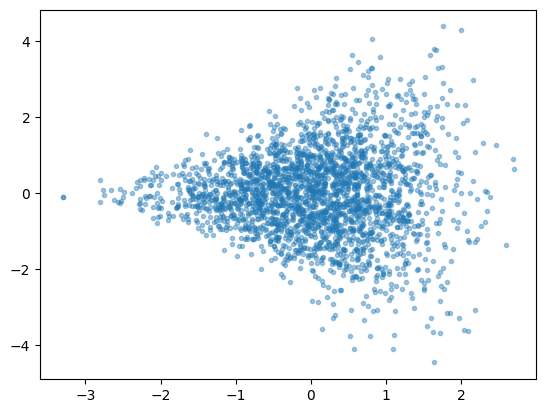

In [7]:
import matplotlib.pyplot as plt

# ode_targ = results_dict["aug_ode"][:, -1,:2]
sde_targ = results_dict["aug"][:, -1,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ[:, 0], sde_targ[:, 1], ".", alpha=0.4)

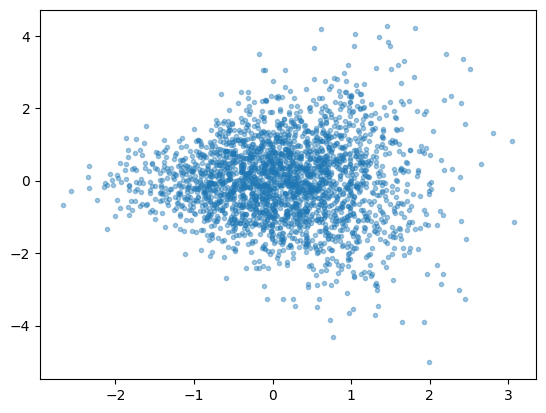

In [8]:
timestep = 90

sde_targ2 = results_dict["aug"][:, timestep,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ2[:, 0], sde_targ2[:, 1], ".", alpha=0.4)

In [9]:
jnp.array(results_dict["is_eval"]).mean()

DeviceArray(0.34542644, dtype=float32)

In [10]:
results_dict["is_eval"]

[0.33989429473876953,
 0.3497891426086426,
 0.5175447463989258,
 -0.1480579376220703,
 0.43273401260375977,
 -0.3008565902709961,
 -0.5175762176513672,
 0.40991830825805664,
 0.5098085403442383,
 0.5473403930664062,
 0.41106462478637695,
 0.34702491760253906,
 0.5793676376342773,
 0.6081180572509766,
 0.25284719467163086,
 0.5756406784057617,
 0.1791977882385254,
 0.5611462593078613,
 0.5987920761108398,
 0.5225334167480469,
 0.5498085021972656,
 0.3615288734436035,
 -0.4106302261352539,
 0.3879561424255371,
 0.6411309242248535,
 0.32573556900024414,
 0.48865509033203125,
 0.47951602935791016,
 0.25105953216552734,
 0.5117607116699219]

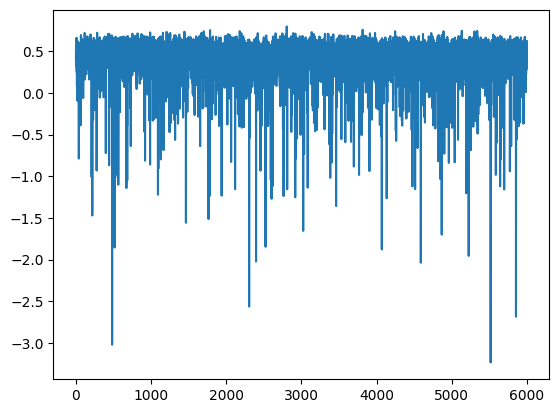

In [11]:
plt.plot(results_dict["is"])

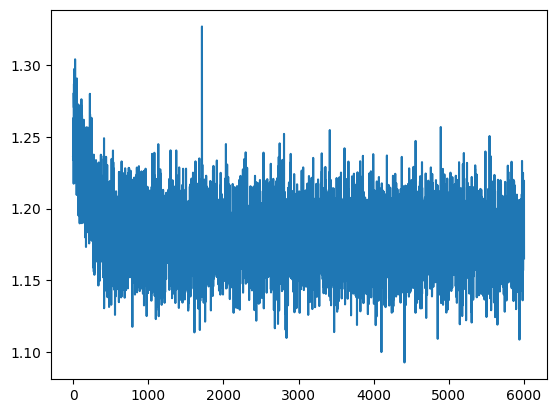

In [12]:
plt.plot(results_dict["elbo"])

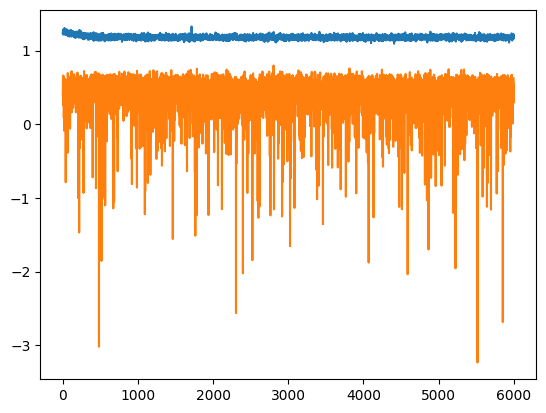

In [13]:
plt.plot(results_dict["elbo"])
plt.plot(results_dict["is"])